In [583]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import wandb
import statistics

Initialize run

In [584]:
# true of creating a new model, false if loading
new_model = True

wandb initialization

In [585]:
if new_model:
    run = wandb.init(project='prediction model for CT')
else:
    run = wandb.init(project='prediction model for CT', id="u859rq9g", resume="allow",) ## fill in id of desired run

In [586]:
epochs = 5
lr = 1e-4
wandb.config.epochs = epochs
wandb.config.learning_rate = lr

Data

In [587]:
df = pd.read_csv("data/filtered_ds.csv")
df

,id,patient_id,domain_ids,domain_scores,start_time_min
0,9256459,143524,1,0.0000,2017-12-02 13:28:49
1,9319566,143524,1,0.0000,2017-12-08 11:22:58
2,9346944,143524,1,0.0860,2017-12-11 11:47:19
3,9524559,143524,1,0.0860,2017-12-24 14:11:56
4,9525898,143524,1,0.0860,2017-12-24 16:38:01
...,...,...,...,...,...
2194129,19768354,312036,12,0.9000,2019-09-05 23:40:37
2194130,19770319,312036,12,0.9070,2019-09-20 03:42:08
2194131,20071746,312036,12,0.9070,2019-09-22 20:02:43
2194132,20160407,312036,12,0.9000,2019-09-26 19:52:09


In [588]:
df = df.sort_values(by=["patient_id", "start_time_min"])

Create training data

In [589]:
def process_row(row):
    values_a = [float(x.strip()) for x in str(row['domain_ids']).split(',')]
    values_b = [float(x.strip()) for x in str(row['domain_scores']).split(',')]
    return values_a, values_b

In [590]:
def create_training_data(data : pd.DataFrame):
    score = np.zeros((1,14))
    scores = np.zeros((len(data), 14))
    i = 0

    for idx, row in data.iterrows():
        domains, domain_scores = process_row(row)
        for j in range(len(domains)):
            score[0, int(domains[j] - 1)] = domain_scores[j]
        # set score to the score list average
        scores[i] = score
        i += 1
    
    scores_df = pd.DataFrame(scores, columns=["domain %d score" % i for i in range(1, 15)])
    data.reset_index(drop=True, inplace=True)
    scores_df.reset_index(drop=True, inplace=True)
    data = pd.concat([data, scores_df], axis=1)
    return data

In [591]:
data = df.groupby("patient_id").apply(create_training_data).reset_index(drop=True)

In [592]:
data

,id,patient_id,domain_ids,domain_scores,start_time_min,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
0,9316748,14696,"1,13","0.5850,0.7030",2017-12-06 14:20:08,0.585,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.703,0.0
1,9316749,14696,"4,5","0.6430,0.4500",2017-12-06 14:27:53,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.703,0.0
2,9316750,14696,9,0.9500,2017-12-06 14:38:16,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.000,0.0,0.000,0.703,0.0
3,9316751,14696,10,0.8070,2017-12-06 14:44:54,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.807,0.0,0.000,0.703,0.0
4,9316752,14696,"12,13","0.5070,0.7030",2017-12-06 14:50:15,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.807,0.0,0.507,0.703,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194129,25142627,408963,5,0.6130,2020-06-26 06:55:04,0.000,0.0,0.63,0.800,0.613,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194130,25142628,408963,5,0.6260,2020-06-26 06:55:13,0.000,0.0,0.63,0.800,0.626,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194131,25142634,408963,5,0.6520,2020-06-26 07:01:30,0.000,0.0,0.63,0.800,0.652,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194132,25157982,408963,5,0.6900,2020-07-03 23:15:37,0.000,0.0,0.63,0.800,0.690,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0


In [593]:
model_data = data[["domain %d score" % i for i in range(1, 15)]]
model_data

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
0,0.585,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.703,0.0
1,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.703,0.0
2,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.000,0.0,0.000,0.703,0.0
3,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.807,0.0,0.000,0.703,0.0
4,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.807,0.0,0.507,0.703,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194129,0.000,0.0,0.63,0.800,0.613,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194130,0.000,0.0,0.63,0.800,0.626,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194131,0.000,0.0,0.63,0.800,0.652,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194132,0.000,0.0,0.63,0.800,0.690,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0


In [594]:
def filter_nonzero_rows(df, max_zeros):
    # Count number of zeros in each row
    zeros_count = (df == 0).sum(axis=1)
    
    # Filter rows with at most max_zeros number of zeros
    non_zero_rows = df[zeros_count <= max_zeros]
    return non_zero_rows

In [595]:
model_data = filter_nonzero_rows(model_data, 3)
model_data.shape

(961912, 14)

In [596]:
model_data = model_data.to_numpy()

In [597]:
(l, w) = model_data.shape

In [598]:
temp = np.zeros((l, w*2))
for i in range(l):
    for d in range(w):
        p = model_data[i, d]
        # update output array
        if p == 0:
            # print("shouldn't be here")
            missing_ind = np.random.choice(2, 1)[0]
            temp[i, d*2] = missing_ind
            temp[i, d*2+1] = missing_ind
        else:
            temp[i, d*2] = p # score
            temp[i, d*2+1] = 1-p # 1-score

model_data = copy.deepcopy(temp)

In [599]:
model_data.shape

(961912, 28)

Model

In [600]:
if new_model:
    class AE(torch.nn.Module):
        def __init__(self):
            super().__init__()
            n_domains = 14
            hidden1 = n_domains * 4
            hidden2 = n_domains
            
            self.encoder = torch.nn.Sequential(
                torch.nn.Linear(n_domains * 2, hidden1),
                torch.nn.Sigmoid(),
                torch.nn.Linear(hidden1, hidden2)
            )
            
            self.decoder = torch.nn.Sequential(
                torch.nn.Linear(hidden2, hidden1),
                torch.nn.Sigmoid(),
                torch.nn.Linear(hidden1, n_domains * 2),
                torch.nn.Sigmoid()
            )
    
        def forward(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

    # Model Initialization
    model = AE()

In [601]:
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(),
                             lr = lr)

In [602]:
# Extract model metadata
# model_metadata = extract_model_metadata(model)

# Log model metadata to Weights & Biases
# wandb.config.update(model_metadata)
wandb.watch(model, log='all')

[]

Training

In [603]:
from sklearn.model_selection import train_test_split
x_train, x_val = train_test_split(model_data, test_size=0.20)

In [604]:
def missing(arr):
    return arr[0] == arr[1]

In [607]:
def train_model(x_train, x_val, epochs, model, optimizer, loss_function):
  model.train()
  outputs = []
  losses = []
  val_losses = []
  epoch_loss = []
  val_epoch_loss = []

  for epoch in range(epochs):
    for session in x_train:

      optimizer.zero_grad()

      # Output of Autoencoder
      session_rs = session.reshape(-1, w * 2)
      session_t = torch.from_numpy(session_rs)
      session_t = session_t.clone().detach().requires_grad_(True).type(torch.float32)
      reconstructed = model(session_t)

      # handle missing value
      missing_exists = False
      missing_domains = []
      for domain in range(w):
        if missing(session[domain*2:domain*2+2]):
          missing_exists = True
          missing_domains.append(domain)
          
      if missing_exists:
        session_dc = copy.deepcopy(session)
        for d in missing_domains:
          target = reconstructed.detach().numpy()[0][d*2:d*2+2]
          session_dc[d*2:d*2+2] = target
        session_dc = session_dc.reshape(-1, w * 2)
        session_t = torch.from_numpy(session_dc)
        session_t = session_t.clone().detach().requires_grad_(True).type(torch.float32)
        
      # Calculating the loss function
      loss = loss_function(reconstructed, session_t)
      
      loss.backward()
      optimizer.step()
      # print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
      
      # Storing the losses in a list for plotting
      epoch_loss.append(loss.item())

    losses.append(statistics.mean(epoch_loss))
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {statistics.mean(epoch_loss):.4f}')
    epoch_loss = []
    outputs.append((epochs, session_t, reconstructed))

    with torch.no_grad():
      for val in x_val:
        val_rs = val.reshape(-1, w * 2)
        val_t = torch.from_numpy(val_rs)
        val_t = val_t.clone().detach().type(torch.float32)
        answer = model(val_t)
        val_loss = loss_function(answer, val_t)
        val_epoch_loss.append(val_loss.item())
    val_losses.append(statistics.mean(val_epoch_loss))
    val_epoch_loss = []
  return losses, val_losses, outputs, model

In [608]:
if new_model:
    losses, val_losses, outputs, model = train_model(x_train, x_val, epochs, model, optimizer, loss_function)

Epoch [1/5], Loss: 0.0067


wandb: Network error (ReadTimeout), entering retry loop.


Epoch [2/5], Loss: 0.0006
Epoch [3/5], Loss: 0.0003
Epoch [4/5], Loss: 0.0002
Epoch [5/5], Loss: 0.0001


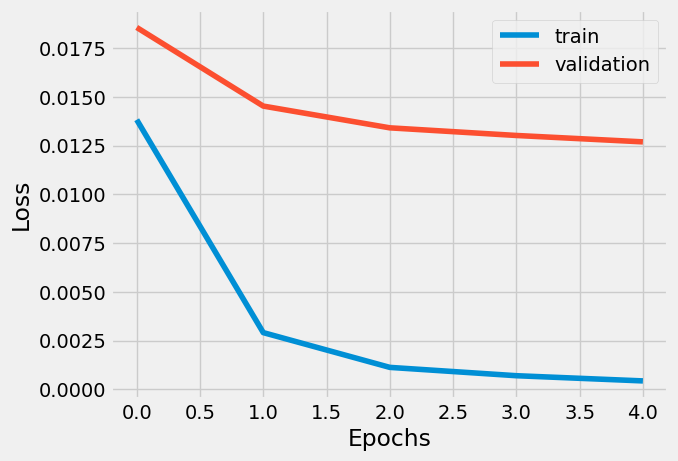

In [ ]:
if new_model:    
    # Defining the Plot Style
    plt.style.use('fivethirtyeight')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    # Plotting
    with torch.no_grad():
        plt.plot(losses)
        plt.plot(val_losses)
        plt.legend(["train", "validation"])

    wandb.log(
        {
            "train val loss": wandb.plot.line_series(
                xs=range(1, epochs + 1),
                ys=[losses, val_losses],
                keys=["Train", "Validation"],
                title="training and validation loss",
                xname="epochs",
            )
        }
    )

In [ ]:
np.mean(x_train, axis=0)

array([0.5215216 , 0.47871741, 0.50677498, 0.4929211 , 0.84532596,
       0.15460618, 0.40428904, 0.59576997, 0.26100246, 0.73879984,
       0.54611453, 0.45368187, 0.50218366, 0.4974298 , 0.63580881,
       0.36497608, 0.36058551, 0.63910761, 0.5243227 , 0.47570681,
       0.81493215, 0.18466656, 0.41760979, 0.58245808, 0.58535285,
       0.4146324 , 0.67489514, 0.32450882])

In [ ]:
zero_test = np.zeros((5000, 14))

In [ ]:
temp = np.zeros((5000, 14*2))
for i in range(5000):
    for d in range(14):
        p = zero_test[i, d]
        # update output array
        if p == 0:
            # print("shouldn't be here")
            missing_ind = np.random.choice(2, 1)[0]
            temp[i, d*2] = missing_ind
            temp[i, d*2+1] = missing_ind
        else:
            temp[i, d*2] = p # score
            temp[i, d*2+1] = 1-p # 1-score

zero_test = copy.deepcopy(temp)

In [ ]:
model.eval()
total = np.zeros((1, 28))
with torch.no_grad():
    for row in zero_test:
        temp = row.reshape(-1, 14 * 2)
        temp = torch.from_numpy(temp)
        temp = temp.clone().detach().type(torch.float32)
        output = model(temp).detach().numpy()[0]
        total = output + total

total = total/5000
total

array([[0.49618513, 0.5036642 , 0.49834989, 0.50172693, 0.47399061,
        0.52597895, 0.48405984, 0.51632944, 0.52337387, 0.47643074,
        0.49071705, 0.50961349, 0.50723748, 0.49265565, 0.45636299,
        0.5432872 , 0.51854163, 0.48147839, 0.48733454, 0.51276482,
        0.46018463, 0.53983072, 0.51223567, 0.48776224, 0.49639325,
        0.50373069, 0.48803923, 0.51195667]])

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(np.reshape(np.mean(x_train, axis=0), (total.shape)), total)

0.03236298548607849

### See how this changes the score trajectory

In [ ]:
data

,id,patient_id,domain_ids,domain_scores,start_time_min,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
0,9316748,14696,"1,13","0.5850,0.7030",2017-12-06 14:20:08,0.585,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.703,0.0
1,9316749,14696,"4,5","0.6430,0.4500",2017-12-06 14:27:53,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.703,0.0
2,9316750,14696,9,0.9500,2017-12-06 14:38:16,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.000,0.0,0.000,0.703,0.0
3,9316751,14696,10,0.8070,2017-12-06 14:44:54,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.807,0.0,0.000,0.703,0.0
4,9316752,14696,"12,13","0.5070,0.7030",2017-12-06 14:50:15,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.807,0.0,0.507,0.703,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194129,25142627,408963,5,0.6130,2020-06-26 06:55:04,0.000,0.0,0.63,0.800,0.613,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194130,25142628,408963,5,0.6260,2020-06-26 06:55:13,0.000,0.0,0.63,0.800,0.626,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194131,25142634,408963,5,0.6520,2020-06-26 07:01:30,0.000,0.0,0.63,0.800,0.652,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194132,25157982,408963,5,0.6900,2020-07-03 23:15:37,0.000,0.0,0.63,0.800,0.690,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0


In [609]:
import random
pid = random.choice(pd.unique(data["patient_id"]))
pid

201992

In [610]:
# pid = 286788

In [611]:
column_names = ["domain %d score" % i for i in range(1, 15)]

In [612]:
def get_score(data : pd.DataFrame):
    updated_domain_pct = dict() # keeps updated domain pct
    score = 0 # score for each session, an average of all available domains
    scores = []

    data = data.sort_values(by="start_time_min").reset_index(drop=True)
    column_names = ["domain %d score" % i for i in range(1, 15)]

    for idx, row in data.iterrows():
        domain_ids, _ = process_row(row)
        for j in range(len(domain_ids)):
            col = column_names[int(domain_ids[j] - 1)]
            updated_domain_pct[col] = row[col] # update domain pct to the latest one
        # find sum of all domain pct
        for k, v in updated_domain_pct.items():
            score += float(v)
        # take average of domain pct, add to list, reset score to 0
        score /= len(updated_domain_pct)
        scores.append(score)
        score = 0
    # return scores list
    return scores

In [613]:
no_pred_scores = get_score(data[data.patient_id == pid])

In [614]:
temp = data[data.patient_id == pid].copy(deep=True)
patient_data = temp.sort_values(by='start_time_min').reset_index()
patient_data_scores = patient_data[column_names].to_numpy()
patient_data_scores.shape

(655, 14)

In [615]:
l, w = patient_data_scores.shape

In [616]:
temp = np.zeros((l, w*2))
for i in range(l):
    for d in range(w):
        p = patient_data_scores[i, d]
        # update output array
        if p == 0:
            # print("shouldn't be here")
            missing_ind = np.random.choice(2, 1)[0]
            temp[i, d*2] = missing_ind
            temp[i, d*2+1] = missing_ind
        else:
            temp[i, d*2] = p # score
            temp[i, d*2+1] = 1-p # 1-score

patient_data_scores = copy.deepcopy(temp)

In [617]:
input_tensor = torch.tensor(patient_data_scores, dtype=torch.float32)

predictions = []

for row in input_tensor:
    # Reshape row to (1, 28) if necessary
    row = row.unsqueeze(0) if len(row.shape) == 1 else row
    # Forward pass through the model
    with torch.no_grad():
        # print(model(row))
        output = model(row)
        
    # Append predictions to the list
    predictions.append(output.numpy())

predictions = np.array(predictions)

In [618]:
predictions = predictions.reshape(l, w * 2)
predictions = predictions[:, ::2]

In [619]:
patient_data.iloc[:, -14:] = predictions

In [620]:
patient_data['score'] = patient_data.iloc[:, -14:].mean(axis=1)

In [621]:
patient_data["no_pred_score"] = no_pred_scores

In [622]:
patient_data["start_time_min"] = pd.to_datetime(patient_data["start_time_min"])

Text(0.5, 1.0, '201992')

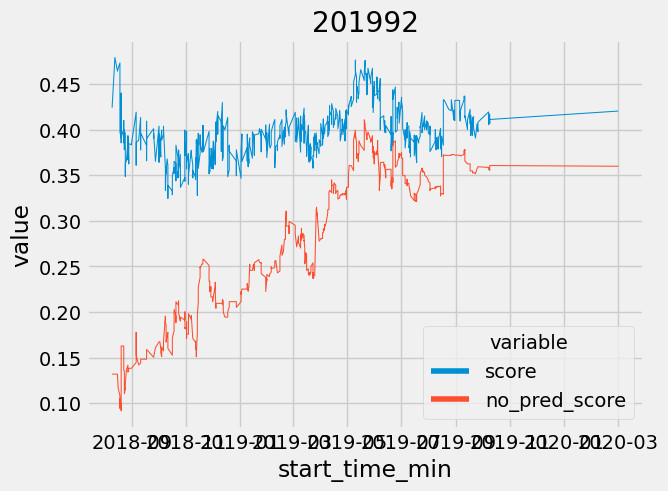

In [623]:
sns.lineplot(x="start_time_min", y="value", hue='variable', data=pd.melt(patient_data[["start_time_min", "score", "no_pred_score"]], ['start_time_min']),linewidth=0.75).set_title(pid)

In [624]:
if new_model: # if this is a new model, save the model
    torch.save(model.state_dict(), "model/model.pt")
    artifact = wandb.Artifact('model', type='model')
    artifact.add_file('model/model.pt')
    run.log_artifact(artifact)

In [625]:
wandb.unwatch()
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Bad pipe message: %s [b'1\x8c\x13[n1\\\x82\xb7\x18ml\xdc\xd8\xa8[|m\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0']
Bad pipe message: %s [b'|tiF\x11k\x9e]?\xb2\x83\x04\xf1.\xe7\xef\xb8G\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\